# Python script to plot data from 01EMMA_CYL

In [16]:
from netCDF4 import Dataset
import requests
from lxml import etree
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widget
from IPython.display import display


global loadedfiles
loadedfiles = [[],[]]

## plotting function

In [34]:
def plot_func(variable, rootgrp, vector):
    # Figure size
    fig_xsize = 15
    fig_ysize = 10
    font_size = 25
    fig = plt.figure(num=0, figsize=(fig_xsize, fig_ysize), dpi=60,
                     facecolor='w', edgecolor='w')
    plt.rcParams.update({'font.size': font_size})
    plt.gca().set_aspect('equal')
    
    #axis names
    xaxis_name = 'i'
    yaxis_name = 'j'
    plt.xlabel(xaxis_name)
    plt.ylabel(yaxis_name)
    contourcolor = plt.cm.coolwarm
    xlin = np.linspace(0, len(rootgrp.variables['lon'])-1, len(rootgrp.variables['lon']))
    x, y = np.meshgrid(xlin, xlin)
    if variable == 'norm':
        norm = np.sqrt(rootgrp.variables['u'][0, 0, :, :]**2 +
                       rootgrp.variables['v'][0, 0, :, :]**2)
        mycontour = plt.contourf(norm, 50, cmap=contourcolor)
        cbar = plt.colorbar(mycontour)
        cbar.ax.set_ylabel('norm (m/s)')
    else:
        varplot = rootgrp.variables[variable][0, 0, :, :]
        mycontour = plt.contourf(varplot, 50, cmap=contourcolor)
        cbar = plt.colorbar(mycontour)
        cbar.ax.set_ylabel(rootgrp.variables[variable].name +
                           " (" + rootgrp.variables[variable].units + ")")
    if vector:
        plt.quiver(x, y, rootgrp.variables['u'][0, 0, :, :],
                   rootgrp.variables['v'][0, 0, :, :])


def get_folders(base_url):
    catalog_file = requests.get(base_url + 'catalog.xml')
    tree = etree.fromstring(catalog_file.content)
    folders = []
    for children in tree[2]:
        if not '.' in children.get('name'):
            folders.append(children.get('name'))
    return folders        
        
def create_plot():
    base_url = 'http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/'
    folders = get_folders(base_url)

    interactive_plot = widget.interactive(g,
                                          folder=widget.Select(options=folders,
                                                               description='Select a folder',
                                                               value='cc'
                                                               ),
                                          file=widget.IntText(value=1,
                                                              description='Select a file number:',
                                                             ),
                                          variable=widget.ToggleButtons(options=['u', 'v', 'norm'],
                                                                        description='Variable:',
                                                                        disabled=False,
                                                                        button_style='',
                                                                       ),
                                          vector=widget.Checkbox(value=False,
                                                                 description='Display vectors',
                                                                 disabled=False
                                                                ),
                                         );

    output = interactive_plot.children[-1]
    output.layout.height = '650px'
    display(interactive_plot)

    
def g(folder, file, variable, vector):
    url_base = 'http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/' + folder + '/'
    catalog_file = requests.get(url_base + 'catalog.xml')
    tree = etree.fromstring(catalog_file.content)
    
    files = []
    for children in tree[2]:
        if '.nc' in children.get("name"):
            files.append(children.get("name"))
    print(str(len(files)) + ' files in folder ' + folder)        
    if file > len(files):
        print('No file with number' + str(file))
    else:
        if files[file-1] in loadedfiles[0]:
            rootgrp = loadedfiles[1][loadedfiles[0].index(files[file-1])]
        else:
            url = url_base + files[file-1]
            rootgrp = Dataset(url)
            loadedfiles[0].append(files[file-1])
            loadedfiles[1].append(rootgrp)
        plot_func(variable, rootgrp, vector)
        plt.show()

100 files in folder cc


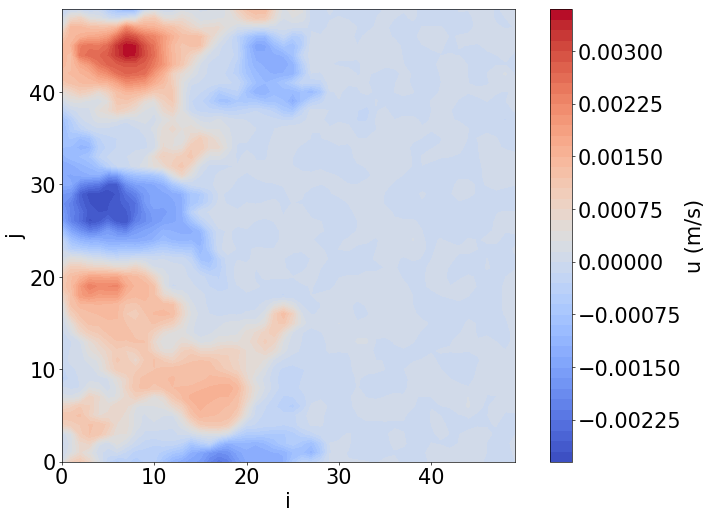

In [33]:
create_plot()